In [2]:
import tensorflow as tf
import datetime

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2022-01-01 08:04:18--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1.92M  --.-KB/s    in 0.06s   

2022-01-01 08:04:18 (33.8 MB/s) - ‘pollution.csv’ saved [2010492/2010492]



In [4]:
lines = []
with open("pollution.csv") as handler:
    for line in handler:
        if line.find("NA") != -1:
            continue
        lines.append(line
                    .replace("NW", "0")
                    .replace("NE", "1")
                    .replace("W", "2")
                    .replace("E", "3")
                    .replace("N", "4")
                    .replace("S", "5")
                    .replace("SW", "6")
                    .replace("SE", "7")
                    .replace("cv", "8")
                    .replace("\n", "")
                    .replace("\r", "").replace("4o", "40"))

In [60]:
print("total size of dataset : -")
print(len(lines))
print("total features are : -")
print(len(lines[0].split(',')))
print("features")
print(lines[0].split(','))
print(lines[:2])

total size of dataset : -
41758
total features are : -
13
features
['40', 'year', 'month', 'day', 'hour', 'pm2.5', 'D32P', 'T3MP', 'PR35', 'cbwd', 'Iws', 'Is', 'Ir']
['40,year,month,day,hour,pm2.5,D32P,T3MP,PR35,cbwd,Iws,Is,Ir', '25,2010,1,2,0,129,-16,-4,1020,53,1.79,0,0']


In [6]:
data = [[] for _ in range(9)]
for line in lines[1:]:
    words = line.split(",")
    time = (datetime.datetime(int(words[1]), int(words[2]), int(words[3]), int(words[4]), 0, 0) - datetime.datetime(1970, 1,1))
    xUnix = time.total_seconds()
    data[0].append(xUnix)
index = 1
take = 4
for i in range(8):
    data[index] = [float(line.split(",")[1:][take]) for line in lines[1:]]
    index += 1
    take += 1

In [7]:
temp = data[1]
data[1]= data[8]
data[8] = temp
print([dataa[100] for dataa in data])

[1262750400.0, 0.0, -26.0, -14.0, 1033.0, 1.0, 17.87, 0.0, 27.0]


In [8]:
import numpy as np
X = np.zeros((len(data[0]) , len(data)-1))
index = 1
for i in range(len(data)-1):
    X[: , i] = data[index]
    index += 1

In [9]:
counter = 0
scalers = []
for i in range(8):
    std = np.std(X[:, i])
    mean = np.mean(X[:, i])
    index = 0
    for value in X[: , i]:
        if (mean + std*3) <= value:
            counter += 1
            value = mean
        X[index, i] = value
        index += 1
    print("found " + str(counter) + " out liers")
    counter = 0

found 580 out liers
found 0 out liers
found 0 out liers
found 0 out liers
found 0 out liers
found 1109 out liers
found 256 out liers
found 769 out liers


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X[:,:7])
print(X_.shape)

clf = LinearRegression()
clf.fit(X_, X[:, 7])
print(clf.predict(X_[:]))

(41757, 36)
[0.32238283 0.33536325 0.41017252 ... 0.04242752 0.05453255 0.05343465]


In [12]:
XNew = np.zeros((1668, 168, 7))
YNew = np.zeros((1668, 2 * 168))
counter = 0
i = 0
while i <= 40008:
    XNew[counter, : , :] = X[i : i+168, :7]
    YNew[counter, :] = X[i+168:i+168+(2 * 168), 7]
    counter += 1
    i += 24

In [13]:
print(counter)

1668


In [14]:
XTest = np.zeros((41757 - 365*24*4, 120, 7))
YTest = np.zeros((41757 - 365*24*4, 24))
index = 365*24*4 - 120 - 24
for i in range(41757 - 365*24*4):
    XTest[i, : , :] = X[index : index+120, :7]
    YTest[i, :] = X[index+120:index+120+24, 7]
    index += 1

In [15]:
print(XNew[1666])
print(YNew.shape)

[[0.         0.66176471 0.45901639 ... 0.         0.0025565  0.        ]
 [0.         0.63235294 0.52459016 ... 0.         0.01295683 0.        ]
 [0.         0.63235294 0.55737705 ... 0.         0.02335716 0.        ]
 ...
 [0.         0.69117647 0.44262295 ... 0.         0.04938702 0.        ]
 [0.         0.69117647 0.44262295 ... 0.         0.05978735 0.        ]
 [0.         0.70588235 0.47540984 ... 0.         0.07018767 0.        ]]
(1668, 336)


In [53]:
from matplotlib import pyplot
test_X = XNew
test_y = YNew
def fit_model(train_X, train_Y):
    model = Sequential()
    model.add(LSTM(330, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(336))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_Y, epochs=300, batch_size=90, validation_data=(test_X, test_y), shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    return(model)

In [17]:
import tensorflow as tf
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential


Epoch 1/300
19/19 [==============================] - 4s 138ms/step - loss: 0.1794 - val_loss: 0.1581
Epoch 2/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1576 - val_loss: 0.1565
Epoch 3/300
19/19 [==============================] - 2s 101ms/step - loss: 0.1568 - val_loss: 0.1561
Epoch 4/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1565 - val_loss: 0.1558
Epoch 5/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1562 - val_loss: 0.1558
Epoch 6/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1561 - val_loss: 0.1557
Epoch 7/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1559 - val_loss: 0.1556
Epoch 8/300
19/19 [==============================] - 2s 103ms/step - loss: 0.1558 - val_loss: 0.1554
Epoch 9/300
19/19 [==============================] - 2s 101ms/step - loss: 0.1557 - val_loss: 0.1553
Epoch 10/300
19/19 [==============================] - 2s 102ms/step - loss: 0.1556 - val_lo

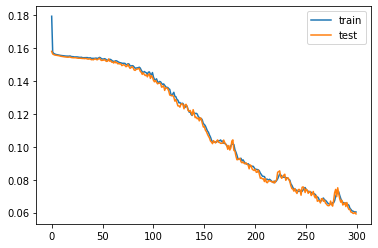

In [54]:
model = fit_model(XNew,YNew)

In [57]:

ynew=model.predict(np.reshape(XNew[1000], (1, 168, 7)))

In [58]:
lis1 = YNew[1000].tolist()
lis2 = ynew[0].tolist()

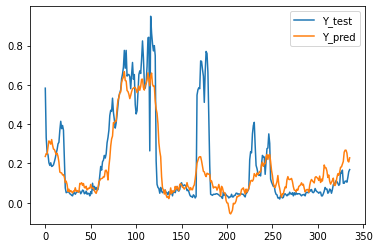

In [59]:
%matplotlib inline
pyplot.plot(lis1, label = "Y_test")
pyplot.plot(lis2, label = "Y_pred")

pyplot.legend()
pyplot.show()